# COVID-19 Situation Reports


# Analysis and Prediction using Supervised Learning Regression

In [10]:
%matplotlib inline

import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [125]:
def split_train_test(inputs, outputs):
    return train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

def train_model(params, search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))
    print('Best score: {}'.format(search.best_score_))
    print('Best parameters: {}'.format(search.best_params_))
    return search.best_estimator_

    #rf_estimator = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                          #max_depth=100, max_features=3, max_leaf_nodes=None,
                          #max_samples=None, min_impurity_decrease=0.0,
                          #min_impurity_split=None, min_samples_leaf=3,
                          #min_samples_split=8, min_weight_fraction_leaf=0.0,
                          #n_estimators=100, n_jobs=None, oob_score=False,
                          #random_state=None, verbose=0, warm_start=False)
    #rf_estimator.fit(in_conf_train, out_conf_train)
    #return rf_estimator
    
def check_results_test(estimator, in_test, out_test, label):
    estimator_pred = estimator.predict(in_test)
    plt.plot(out_test)
    plt.plot(estimator_pred)
    plt.legend(['Input Data', label])
    print('MAE:', mean_absolute_error(out_test, estimator_pred))
    print('MSE:',mean_squared_error(out_test, estimator_pred))
    print('RMSE:', math.sqrt(mean_squared_error(out_test, estimator_pred)))
    print('R^2:', r2_score(out_test, estimator_pred))
    
def plot_cross_val_score(estimator, inputs, outputs, number_cv):
    cv_scores = cross_val_score(estimator, inputs, outputs, cv=number_cv)
    plt.hist(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list
    
def plot_predictions_for_country(df, country, estimator, inputs_list, output, label_out, label_pred, title, cumulative=False):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs) 

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    if cumulative:
        country_pred_output = calc_cumulative(country_pred_output)
    
    print('MAE:', mean_absolute_error(country_outputs, country_pred_output))
    print('MSE:',mean_squared_error(country_outputs, country_pred_output))
    print('RMSE:', math.sqrt(mean_squared_error(country_outputs, country_pred_output)))
    print('R^2:', r2_score(country_outputs, country_pred_output))

    plt.plot(days_list, country_outputs, color='blue', label=label_out)
    plt.plot(days_list, country_pred_output, color='green', label=label_pred)
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(title + "(as of {})".format(last_day))
    plt.legend()
    
def plot_learning_curve(estimator, inputs, outputs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True,
                                       random_state=None, error_score=np.nan, return_times=False)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    
def plot_pred_diff(df, estimator, country, inputs_list, output):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs)

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    diff_list = np.subtract(country_outputs, country_pred_output)
    plt.bar(days_list, diff_list, color='blue', label="")
    plt.show()

## 3) Prediction and Regression
### 3.1) Random Forest
- - -

In [12]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


#### 3.1.1) Regression for Confirmed Cases
- - -

##### 3.1.1.1) Using normalized values as input and using cummulative as output

In [14]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [15]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42])

In [16]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [17]:
# create Random Forest Regressor instance, and check the hyper parameters
rf = RandomForestRegressor()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [18]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


Elapsed time: 3.387279482682546mins
Best score: -29244176.475048285
Best parameters: {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': 100, 'bootstrap': True}


MAE: 331.6844514078751
MSE: 9367432.735244377
RMSE: 3060.6261998559016
R^2: 0.9961392604505938


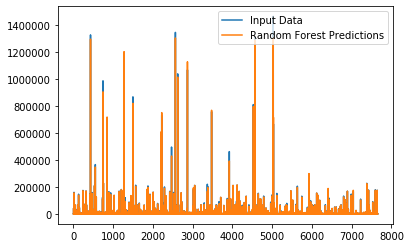

In [19]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

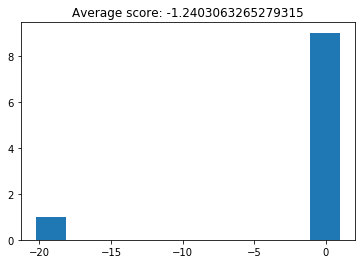

In [20]:
rf_estimator_2 = clone(rf_estimator)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

MAE: 19725.594040608405
MSE: 1287302170.1339996
RMSE: 35878.9934381387
R^2: 0.9944516998540053


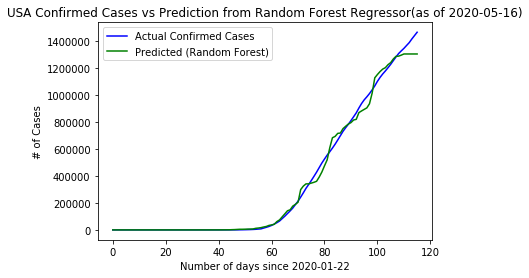

In [21]:
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "USA Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2525.7677285258883
MSE: 18982303.82617608
RMSE: 4356.868580319595
R^2: 0.9978079331015571


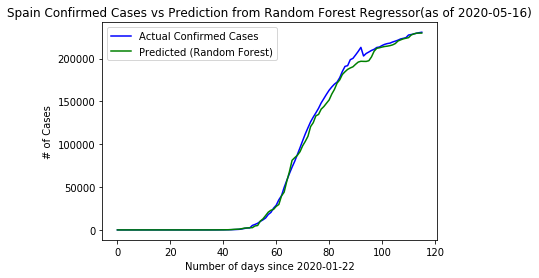

In [22]:
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2869.5278446176576
MSE: 85523625.04189916
RMSE: 9247.898412174474
R^2: 0.9713551593605657


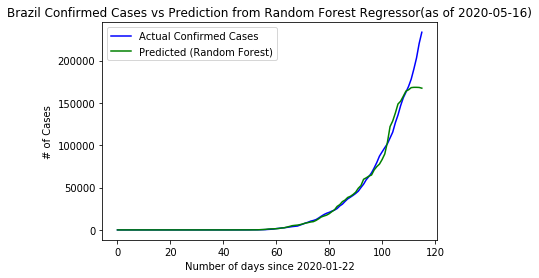

In [23]:
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 343.55265160597025
MSE: 343303.8894904311
RMSE: 585.9214021440342
R^2: 0.9970093918589857


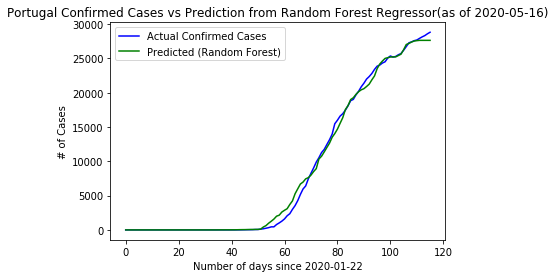

In [24]:
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"],
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2211.265371453204
MSE: 37901878.899749026
RMSE: 6156.450186572537
R^2: 0.9921077004599425


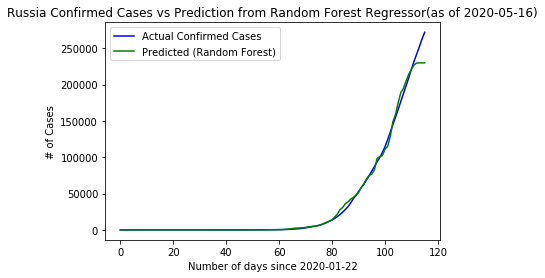

In [25]:
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2450.822125795744
MSE: 18045526.47635088
RMSE: 4248.002645520702
R^2: 0.9976078773727977


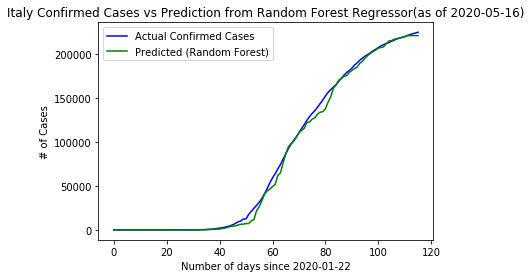

In [26]:
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor"
)

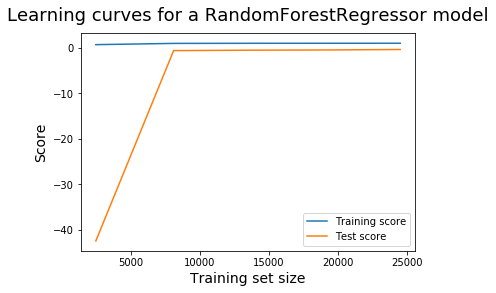

In [27]:
# learning curve
rf_estimator_2 = clone(rf_estimator)

plot_learning_curve(rf_estimator_2, inputs, outputs)

# NON NORMALIZED

In [28]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [29]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42])

In [30]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [31]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


Elapsed time: 2.570942250887553mins
Best score: -16245877.050131975
Best parameters: {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': 110, 'bootstrap': True}


MAE: 289.7220929904595
MSE: 6382638.712092737
RMSE: 2526.3884721263153
R^2: 0.9960681790145869


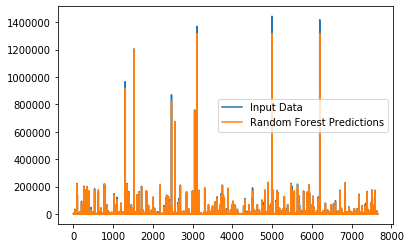

In [32]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

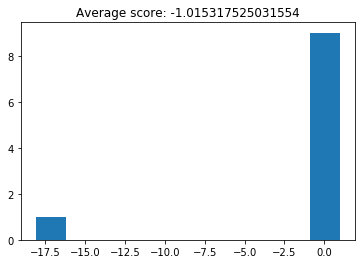

In [33]:
rf_estimator_2 = clone(rf_estimator)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

MAE: 14160.90780881123
MSE: 817528813.9844999
RMSE: 28592.460789244775
R^2: 0.9964764331613665


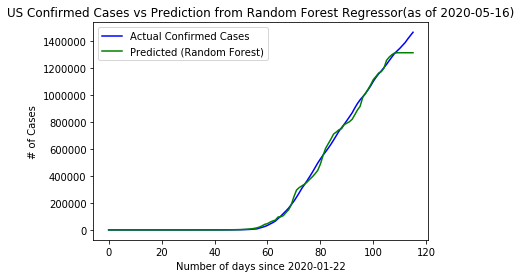

In [34]:
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2652.4283648021055
MSE: 19568950.543892793
RMSE: 4423.6806557314685
R^2: 0.997740187433657


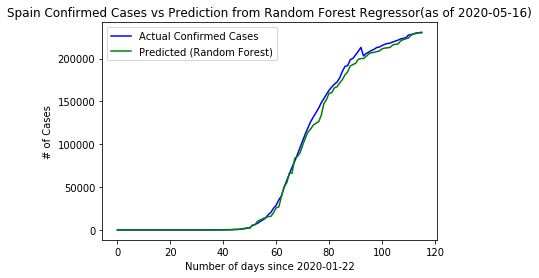

In [35]:
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)",
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2567.973746716151
MSE: 85660753.44208106
RMSE: 9255.30947305821
R^2: 0.9713092302834432


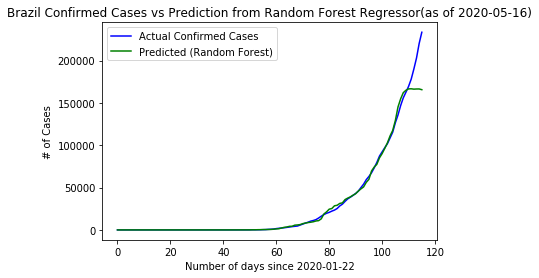

In [36]:
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 352.2644858390565
MSE: 370670.96306356887
RMSE: 608.8275314599109
R^2: 0.9967709902692308


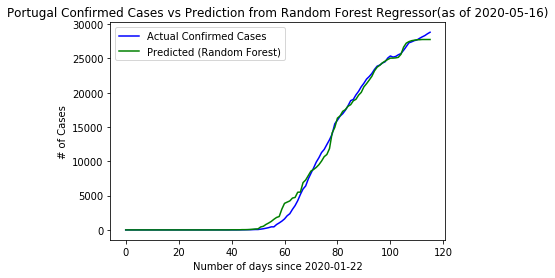

In [37]:
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 3477.648035329961
MSE: 73301260.90222153
RMSE: 8561.615554451248
R^2: 0.9847364952741678


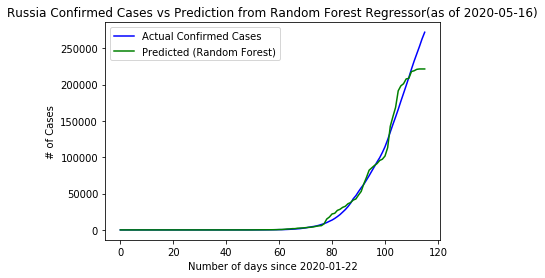

In [38]:
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2761.510131931721
MSE: 22002964.195650198
RMSE: 4690.731733498538
R^2: 0.9970832777538015


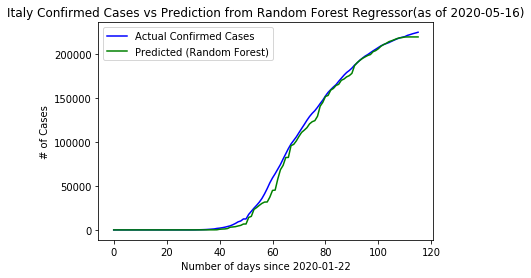

In [39]:
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor"
)

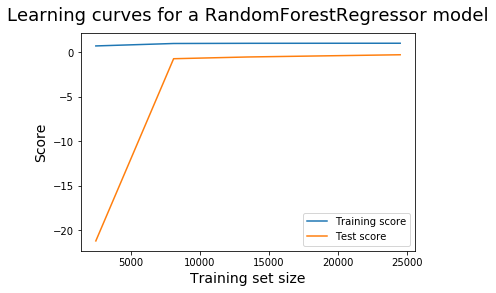

In [40]:
# learning curve
rf_estimator_2 = clone(rf_estimator)

plot_learning_curve(rf_estimator_2, inputs, outputs)

# USING INCREMENTS AS OUTPUT

In [41]:
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [42]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [43]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [44]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


Elapsed time: 3.4721211353937784mins
Best score: -100917.8459495909
Best parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 100, 'bootstrap': True}


MAE: 32.125588584358944
MSE: 60306.10079857633
RMSE: 245.57300502819183
R^2: 0.9566942224447267


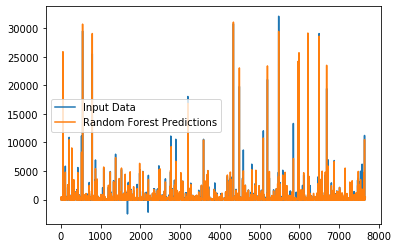

In [45]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

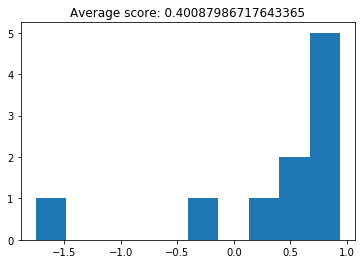

In [46]:
rf_estimator_2 = clone(rf_estimator)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

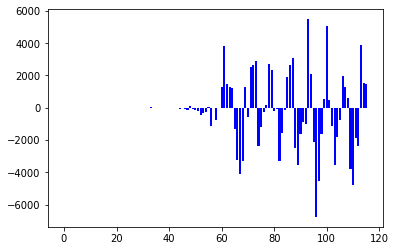

In [47]:
plot_pred_diff(
    df, rf_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed_inc"
)

MAE: 2996.3501138183415
MSE: 29935426.68465478
RMSE: 5471.3276893871725
R^2: 0.9998709776646865


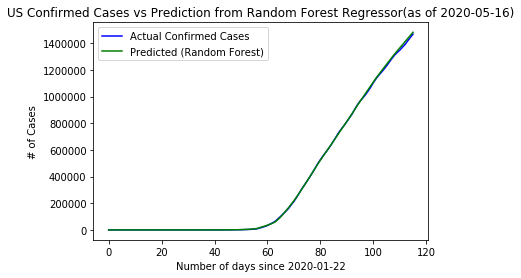

In [48]:
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 3763.1120871635862
MSE: 28421128.46812774
RMSE: 5331.147012428727
R^2: 0.9967179423792878


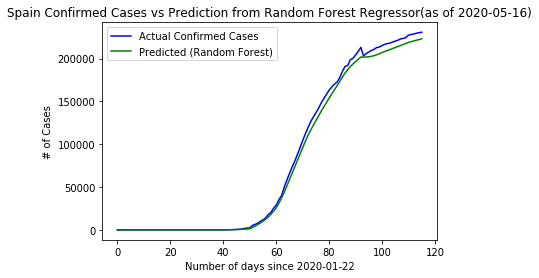

In [49]:
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 874.9570731529645
MSE: 3125244.411551482
RMSE: 1767.8360816409088
R^2: 0.998953246800702


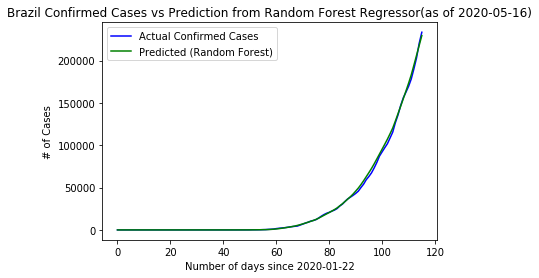

In [50]:
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 471.6957175265344
MSE: 497622.9349265188
RMSE: 705.4239398592302
R^2: 0.9956650791153121


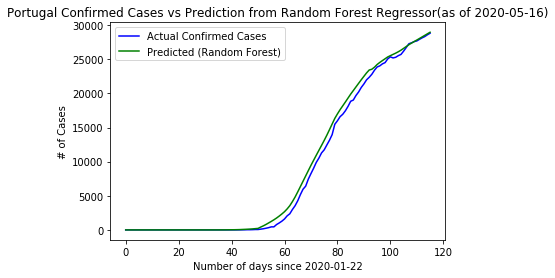

In [51]:
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 631.3396882607013
MSE: 1100719.2632602898
RMSE: 1049.1516874409963
R^2: 0.9997707974805645


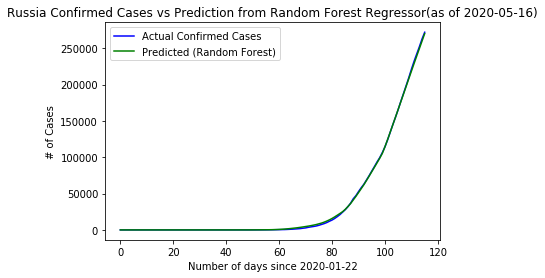

In [52]:
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 4198.9111571368885
MSE: 31259176.50496471
RMSE: 5590.990655059683
R^2: 0.9958562703325262


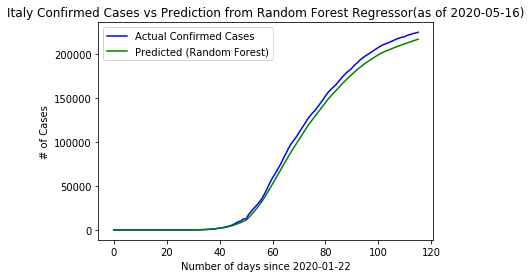

In [53]:
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

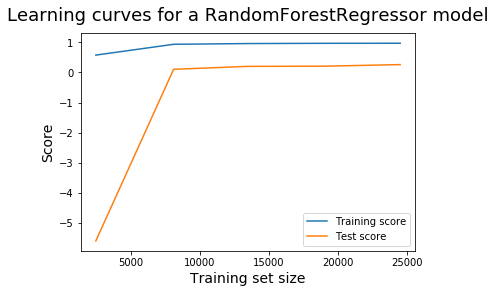

In [54]:
# learning curve
rf_estimator_2 = clone(rf_estimator)

plot_learning_curve(rf_estimator_2, inputs, outputs)

# INCREASES AS INPUTS AND CUMULATIVE AS OUTPUT

In [55]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [56]:
outputs = new_df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42])

In [57]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [58]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.0min finished


Elapsed time: 3.14714541832606mins
Best score: -121454003.23577468
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 90, 'bootstrap': True}


MAE: 780.9215212636639
MSE: 67260975.11219744
RMSE: 8201.278870529732
R^2: 0.9345906852413912


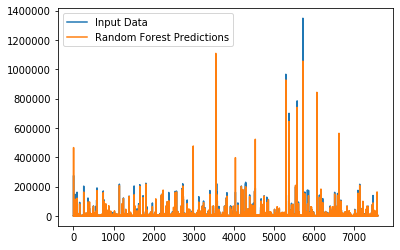

In [59]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

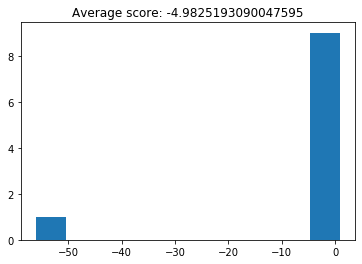

In [60]:
rf_estimator_2 = clone(rf_estimator)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

MAE: 46192.11863240459
MSE: 9291816310.774862
RMSE: 96394.06781941958
R^2: 0.9601084370277488


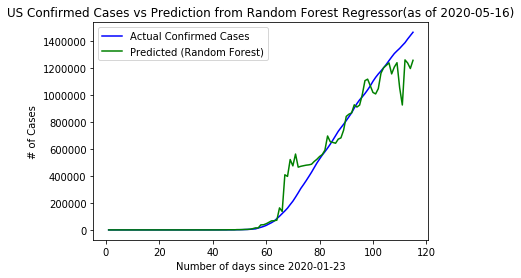

In [61]:
plot_predictions_for_country(
    new_df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 10448.597755683919
MSE: 472997447.0972197
RMSE: 21748.504479554904
R^2: 0.9454780365441994


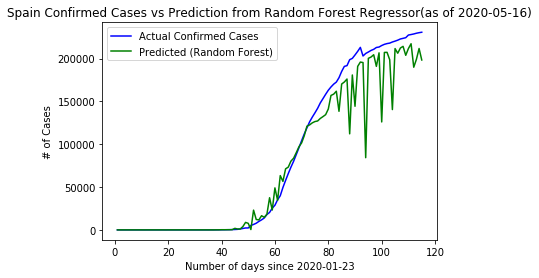

In [62]:
plot_predictions_for_country(
    new_df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 4200.742006207587
MSE: 96415529.17730895
RMSE: 9819.14095923411
R^2: 0.9678991940010381


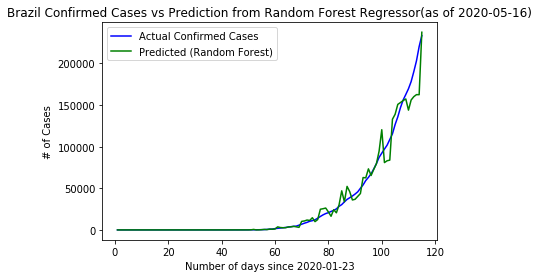

In [63]:
plot_predictions_for_country(
    new_df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 2427.1181224297657
MSE: 46902197.01400365
RMSE: 6848.517869875471
R^2: 0.5925981999485295


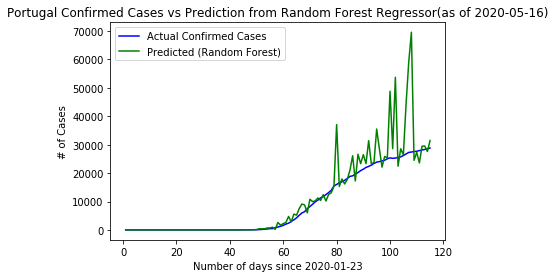

In [64]:
plot_predictions_for_country(
    new_df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 4909.380077505621
MSE: 106017875.41133612
RMSE: 10296.498211107315
R^2: 0.9780612144657547


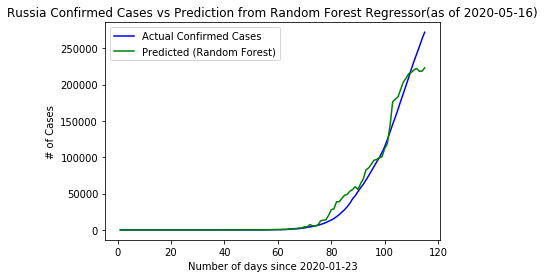

In [65]:
plot_predictions_for_country(
    new_df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor"
)

MAE: 6541.58176154568
MSE: 114869950.69687921
RMSE: 10717.739999499858
R^2: 0.9847836349696233


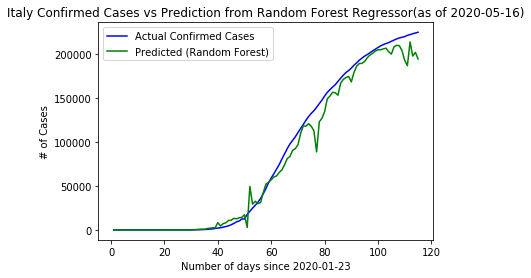

In [66]:
plot_predictions_for_country(
    new_df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor"
)

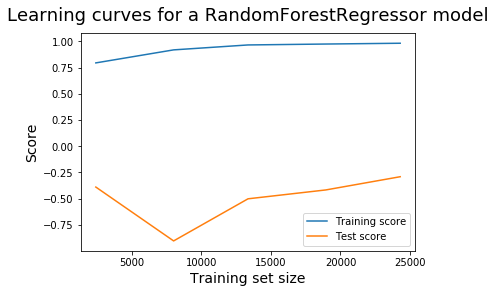

In [67]:
# learning curve
rf_estimator_2 = clone(rf_estimator)

plot_learning_curve(rf_estimator_2, inputs, outputs)

# INCREASES AS INPUTS AND INCREASES AS OUTPUT

In [68]:
inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [69]:
outputs = new_df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [70]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [71]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.7min finished


Elapsed time: 3.168546446164449mins
Best score: -107588.92990679777
Best parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 80, 'bootstrap': True}


MAE: 36.49084320132182
MSE: 91800.52710946249
RMSE: 302.9860180098456
R^2: 0.9476103909418417


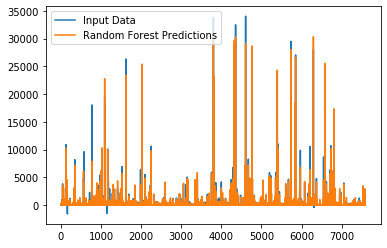

In [72]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

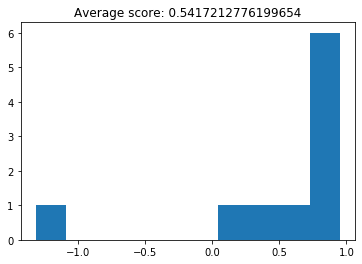

In [73]:
rf_estimator_2 = clone(rf_estimator)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

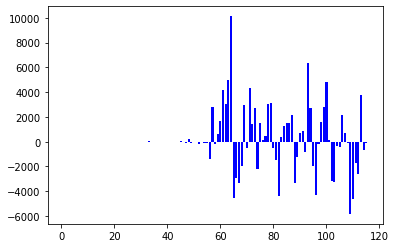

In [74]:
plot_pred_diff(
    new_df, rf_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed_inc"
)

MAE: 12234.691767457203
MSE: 330755253.87779576
RMSE: 18186.677923078634
R^2: 0.9985800037799748


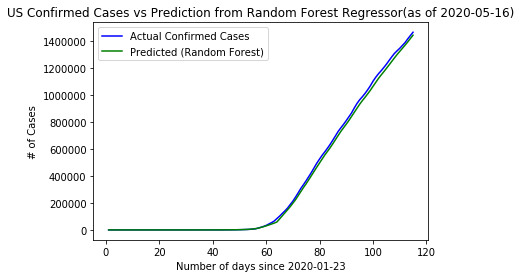

In [75]:
plot_predictions_for_country(
    new_df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 6262.432961560206
MSE: 84502799.10365169
RMSE: 9192.54040533147
R^2: 0.9902594431472794


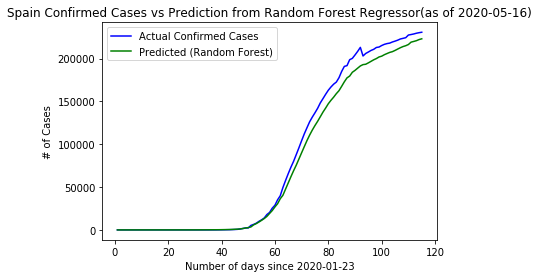

In [76]:
plot_predictions_for_country(
    new_df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 754.9276396549645
MSE: 2812489.7268034383
RMSE: 1677.0479202465976
R^2: 0.99906360326117


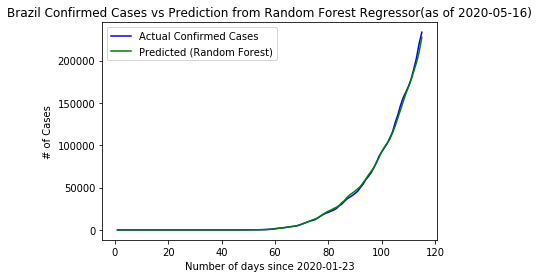

In [77]:
plot_predictions_for_country(
    new_df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 1070.4714331368789
MSE: 2643529.0049790796
RMSE: 1625.8932944627945
R^2: 0.9770377819445175


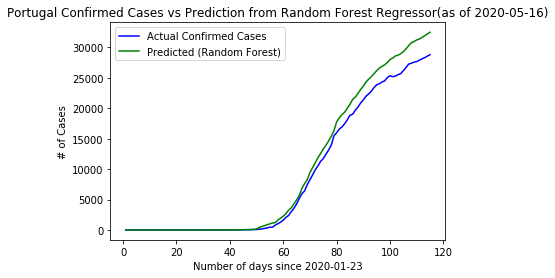

In [78]:
plot_predictions_for_country(
    new_df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 836.6819725460095
MSE: 4353954.819697168
RMSE: 2086.613241522532
R^2: 0.9990990153250617


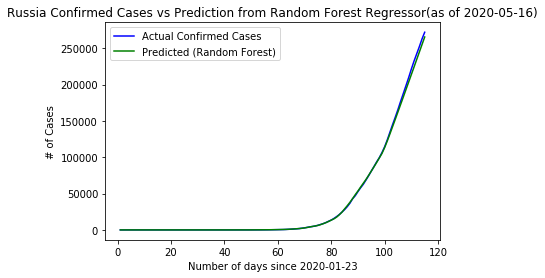

In [79]:
plot_predictions_for_country(
    new_df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 3294.2873385921453
MSE: 19185670.66161054
RMSE: 4380.145050293488
R^2: 0.9974585505924868


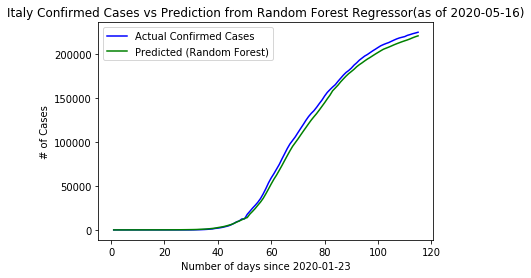

In [80]:
plot_predictions_for_country(
    new_df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

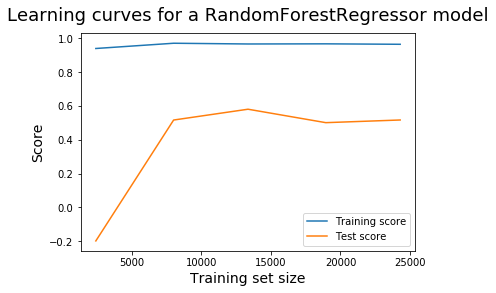

In [81]:
# learning curve
rf_estimator_2 = clone(rf_estimator)

plot_learning_curve(rf_estimator_2, inputs, outputs)

# INCREASES AS OUTPUT, NON NORMALIZED INPUTS

In [82]:
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [83]:
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [84]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [85]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


Elapsed time: 2.4722566843032836mins
Best score: -67010.26349339339
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 110, 'bootstrap': True}


MAE: 37.858529921151636
MSE: 146173.55891240414
RMSE: 382.32650825231065
R^2: 0.9046729313614448


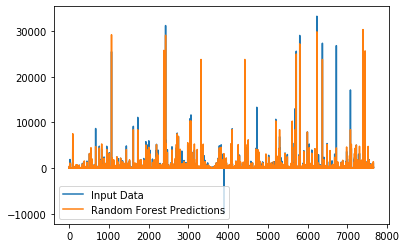

In [86]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

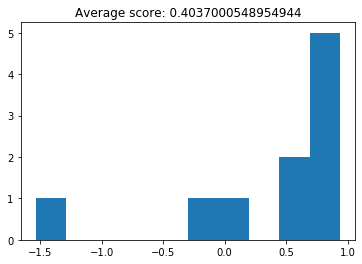

In [87]:
rf_estimator_2 = clone(rf_estimator)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

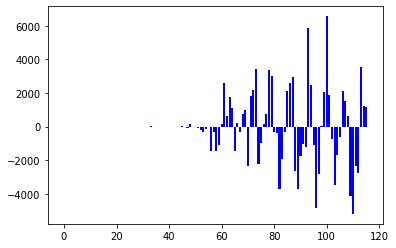

In [88]:
plot_pred_diff(
    df, rf_estimator,
    "US", 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed_inc"
)

MAE: 2366.5808545834475
MSE: 16102008.575661896
RMSE: 4012.73081275855
R^2: 0.9999305999953982


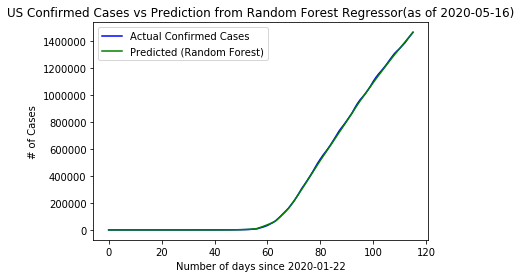

In [89]:
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 2967.2280123746673
MSE: 17208183.0095879
RMSE: 4148.274702763535
R^2: 0.9980128076811389


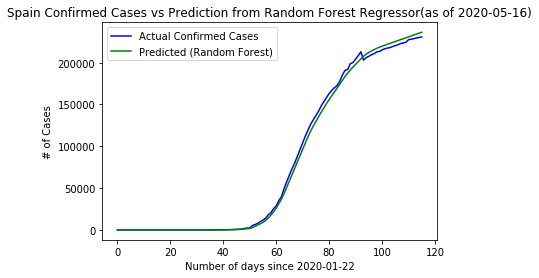

In [90]:
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 1336.6601605592018
MSE: 8006736.570423552
RMSE: 2829.6177428097158
R^2: 0.99731826506431


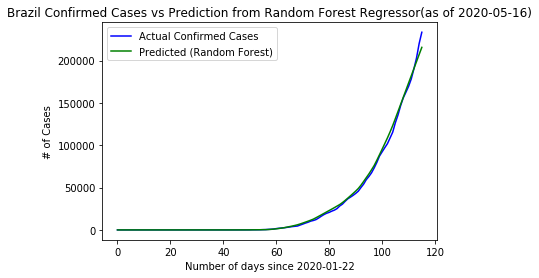

In [91]:
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 476.63012532555314
MSE: 507430.54648952914
RMSE: 712.3415939628467
R^2: 0.9955796424981279


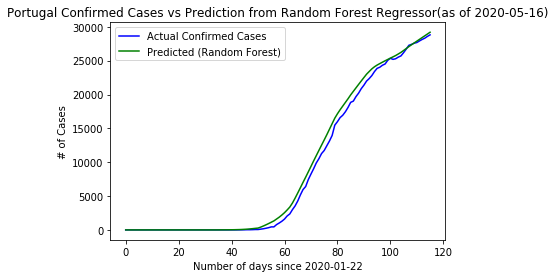

In [92]:
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 635.4952641535762
MSE: 1597967.1821887011
RMSE: 1264.107266883907
R^2: 0.9996672556605868


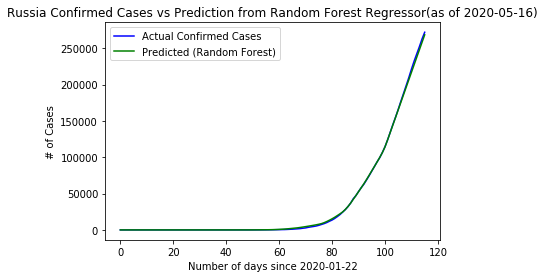

In [93]:
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 5324.246161128665
MSE: 49580984.88477055
RMSE: 7041.376632787835
R^2: 0.9934275236592697


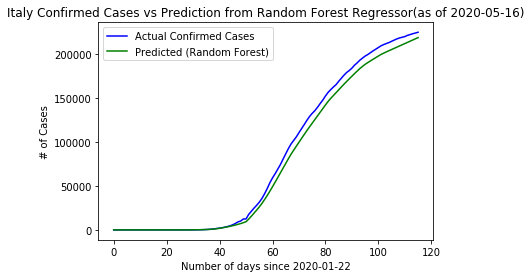

In [94]:
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

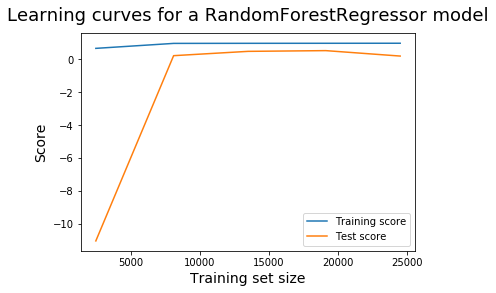

In [95]:
# learning curve
rf_estimator_2 = clone(rf_estimator)

plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.2) Regression for Death Cases
- - -

**(Will only use Increases as output and normalized inputs, as this approach got the best results)**

In [96]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [97]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Deaths_inc"].values
outputs

array([0., 0., 0., ..., 0., 0., 0.])

In [98]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [99]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


Elapsed time: 2.6107540488243104mins
Best score: -742.0894346909341
Best parameters: {'n_estimators': 300, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 80, 'bootstrap': True}


MAE: 3.0094749110084353
MSE: 696.0120960560721
RMSE: 26.382041165460873
R^2: 0.9298819368043156


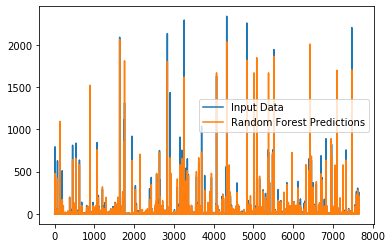

In [100]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

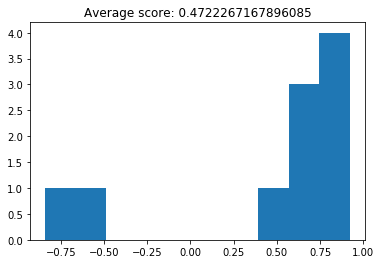

In [101]:
rf_estimator_2 = clone(rf_estimator)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

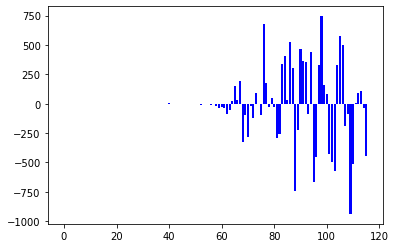

In [102]:
plot_pred_diff(
    df, rf_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths_inc"
)

MAE: 314.0420756485698
MSE: 347004.4846180746
RMSE: 589.0708655315374
R^2: 0.9995756188130599


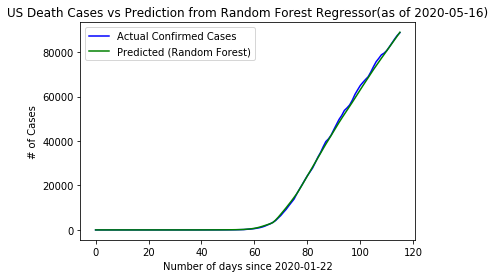

In [103]:
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Death Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 578.8036920200158
MSE: 802951.9927041995
RMSE: 896.07588557231
R^2: 0.9927961845591083


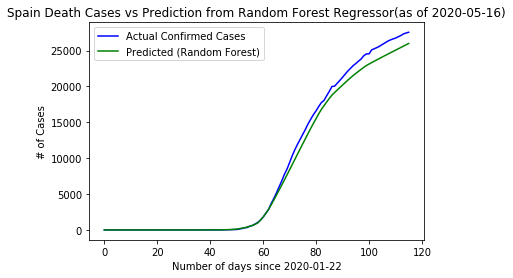

In [104]:
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Death Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 71.33534888176055
MSE: 16641.899464065533
RMSE: 129.00348624771942
R^2: 0.9988203423388156


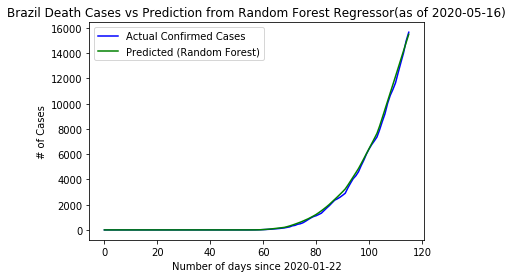

In [105]:
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Death Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 53.61329762106275
MSE: 5388.361503366043
RMSE: 73.40545962914504
R^2: 0.9704080242447282


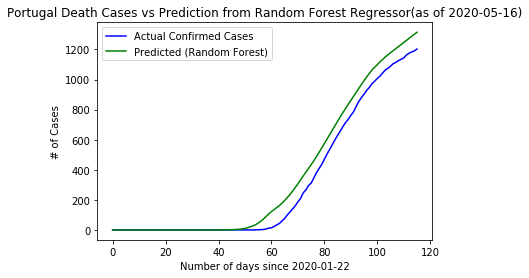

In [106]:
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Death Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 54.24295572242762
MSE: 7879.755545276473
RMSE: 88.76798716472325
R^2: 0.9808448606165392


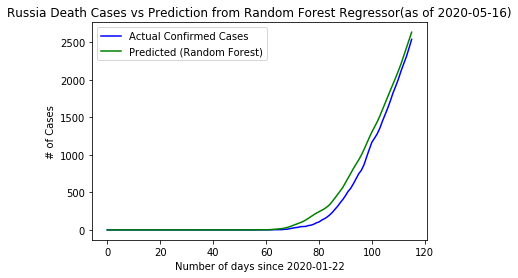

In [107]:
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Death Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 976.2630773990985
MSE: 1978565.71795541
RMSE: 1406.6149856856389
R^2: 0.9861574806940365


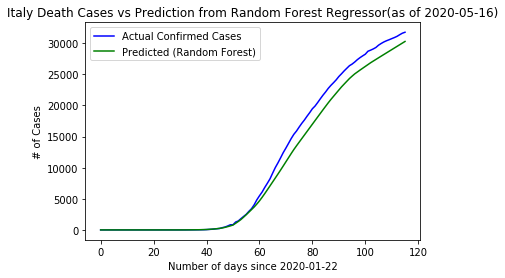

In [108]:
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Death Cases vs Prediction from Random Forest Regressor",
    True
)

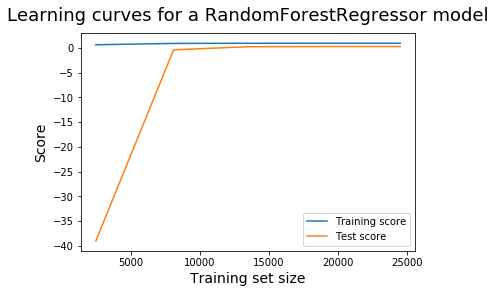

In [109]:
# learning curve
rf_estimator_2 = clone(rf_estimator)

plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.3) Regression for Recovered Cases
- - -

**(Will only use Increases as output and normalized inputs, as this approach got the best results)**

In [110]:
recovered_df = df.loc[df["Recovered"].notna()]

In [111]:
# get the inputs of the data for the machine learning algorithm
inputs = recovered_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 0.27177561, -0.30283255, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [112]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = recovered_df["Recovered_inc"].values
outputs

array([ 0.,  0.,  0., ..., 59.,  0.,  0.])

In [113]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [114]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


Elapsed time: 2.1193952322006226mins
Best score: -105704.55697921799
Best parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 100, 'bootstrap': True}


MAE: 29.224271631869666
MSE: 63820.51898809029
RMSE: 252.62723326690315
R^2: 0.555607479323553


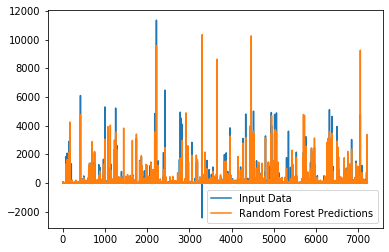

In [115]:
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

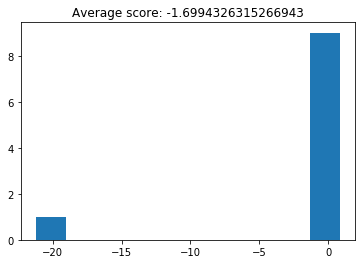

In [116]:
rf_estimator_2 = clone(rf_estimator)

plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

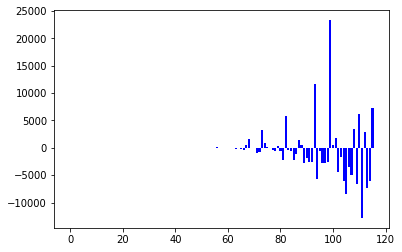

In [117]:
plot_pred_diff(
    recovered_df, rf_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered_inc"
)

MAE: 3065.5836480009953
MSE: 46158790.106292516
RMSE: 6794.026060171724
R^2: 0.9917285798165666


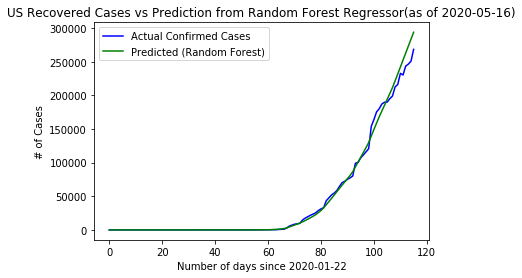

In [118]:
plot_predictions_for_country(
    recovered_df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 2937.272253981041
MSE: 20065200.138956536
RMSE: 4479.41962077193
R^2: 0.9917719272093075


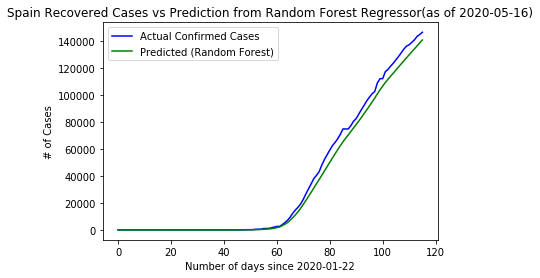

In [119]:
plot_predictions_for_country(
    recovered_df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 1159.3611101566
MSE: 4965027.663957767
RMSE: 2228.2342031208855
R^2: 0.9901320465300975


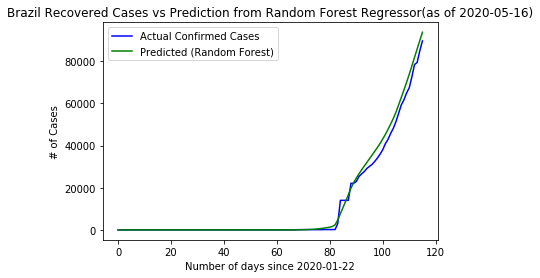

In [120]:
plot_predictions_for_country(
    recovered_df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 557.6300265013398
MSE: 693010.9620646386
RMSE: 832.4727995944604
R^2: 0.14319691920094235


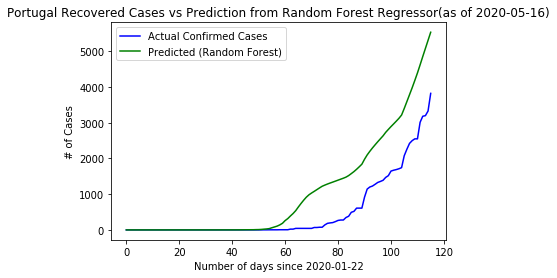

In [121]:
plot_predictions_for_country(
    recovered_df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 575.2616175405291
MSE: 1226875.264767727
RMSE: 1107.6440153622134
R^2: 0.9923473398988853


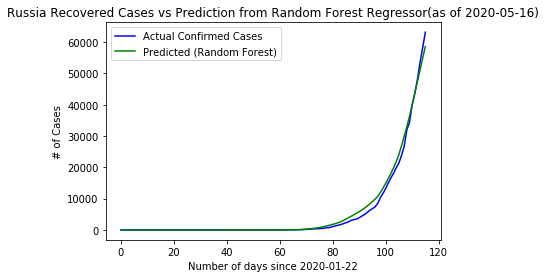

In [122]:
plot_predictions_for_country(
    recovered_df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

MAE: 2423.412574872016
MSE: 12457729.67368459
RMSE: 3529.5509167151263
R^2: 0.9902246963731811


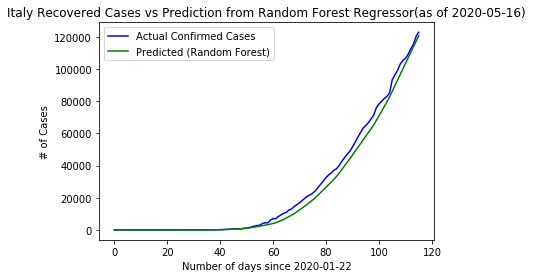

In [123]:
plot_predictions_for_country(
    recovered_df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

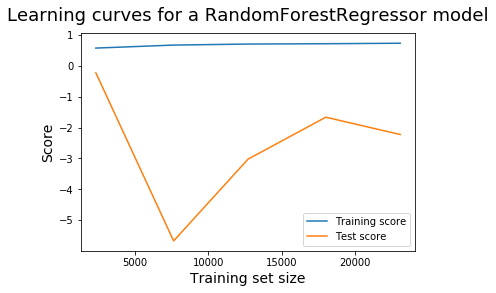

In [124]:
# learning curve
rf_estimator_2 = clone(rf_estimator)

plot_learning_curve(rf_estimator_2, inputs, outputs)